# FORECASTING

In [104]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [105]:
#Load the dataset
dataset = pd.read_csv(r'C:\Users\manch\Downloads\perrin-freres-monthly-champagne.csv')

In [106]:
dataset.head(10)

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946
5,1964-06,3036
6,1964-07,2282
7,1964-08,2212
8,1964-09,2922
9,1964-10,4301


In [107]:
dataset.tail()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
100,1972-05,4618
101,1972-06,5312
102,1972-07,4298
103,1972-08,1413
104,1972-09,5877


In [108]:
dataset.columns = {'Month', 'Sales'}

In [109]:
dataset['Month'] = pd.to_datetime(dataset['Month'], infer_datetime_format = True)

In [110]:
sales_df = dataset.set_index(['Month'])

In [111]:
sales_df.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


Text(0.5, 1.0, 'Data Plot')

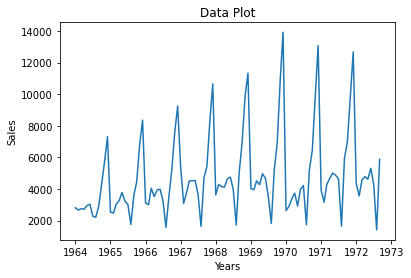

In [113]:
#plot the data
plt.xlabel('Years')
plt.ylabel('Sales')
plt.plot(sales_df)
plt.title('Data Plot')

# Testing For Stationarity

In [115]:
#rolling statistics
roll_mean = sales_df.rolling(window = 12).mean()

In [116]:
roll_mean

,Sales
Month,
1964-01-01,NaN
1964-02-01,NaN
1964-03-01,NaN
1964-04-01,NaN
1964-05-01,NaN
...,...
1972-05-01,5709.500000
1972-06-01,5746.000000
1972-07-01,5718.083333


In [117]:
roll_std = sales_df.rolling(window = 12).std()

In [118]:
roll_std

,Sales
Month,
1964-01-01,NaN
1964-02-01,NaN
1964-03-01,NaN
1964-04-01,NaN
1964-05-01,NaN
...,...
1972-05-01,2943.699327
1972-06-01,2935.100773
1972-07-01,2948.213094


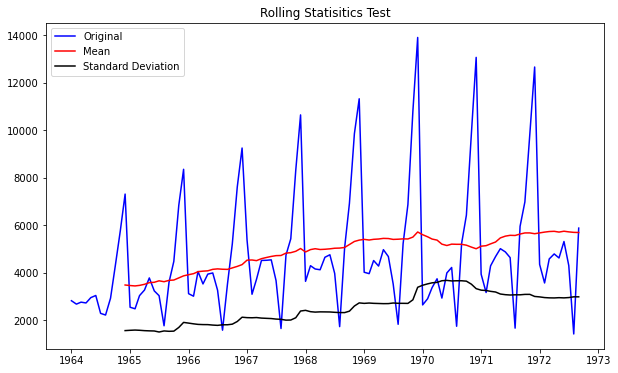

In [127]:
#Plot the mean and standard deviation
plt.figure(figsize=(10,6))
plt.plot(sales_df, color = 'blue', label = 'Original')
plt.plot(roll_mean, color = 'red', label = 'Mean')
plt.plot(roll_std, color = 'black', label = 'Standard Deviation')
plt.title('Rolling Statisitics Test')
plt.legend(loc = 'best')

* Clearly neither the mean nor the standard deviation for a time interval is constant hence the data is not stationary.

* Let us look into another test to check for stationarity called the dickey fuller test

In [128]:
#Perform Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(sales_df['Sales'], autolag = "AIC")

In [130]:
#Null Hypothesis: Data is not stationary
#Alternate Hypothesis:  Data is stationary

def adfuller_test(sales):
    result = adfuller(sales)
    labels = ['ADF Test Statistic', 'p-value', '#Lags used', 'Number of Observations Used']
    for value,label in zip(result, labels):
        print(label + ' : ' + str(value) )
    if result[1] <= 0.05: #If the p-value is less than the Significance value then reject the Null Hypothesis
        print('Data is Stationary')
    else:
        print('Data is Not Stationary')
    


In [131]:
adfuller_test(sales_df['Sales'])

ADF Test Statistic : -1.8335930563276237
p-value : 0.3639157716602447
#Lags used : 11
Number of Observations Used : 93
Data is Not Stationary


* Hence, it is proven that our data is not stationary, Now to make forecases we'll have to convert it into stationary data.

# Conveting Non Stationary Data into Stationary

## Differencing

In [132]:
sales_df['Sales'].shift(12)

Month
1964-01-01       NaN
1964-02-01       NaN
1964-03-01       NaN
1964-04-01       NaN
1964-05-01       NaN
               ...  
1972-05-01    5010.0
1972-06-01    4874.0
1972-07-01    4633.0
1972-08-01    1659.0
1972-09-01    5951.0
Name: Sales, Length: 105, dtype: float64

In [133]:
sales_df['First Seasonal Difference'] = sales_df['Sales'] - sales_df['Sales'].shift(12)

In [136]:
sales_df.head(13)

,Sales,First Seasonal Difference
Month,,
1964-01-01,2815,NaN
1964-02-01,2672,NaN
1964-03-01,2755,NaN
1964-04-01,2721,NaN
1964-05-01,2946,NaN
1964-06-01,3036,NaN
1964-07-01,2282,NaN
1964-08-01,2212,NaN
1964-09-01,2922,NaN


In [139]:
#Test with Dickey- Fuller test
adfuller_test(sales_df['First Seasonal Difference'].dropna()) # Remember to drop NA values to avoid errors.

ADF Test Statistic : -7.626619157213163
p-value : 2.060579696813685e-11
#Lags used : 0
Number of Observations Used : 92
Data is Stationary


* Now, we have made our Data stationary

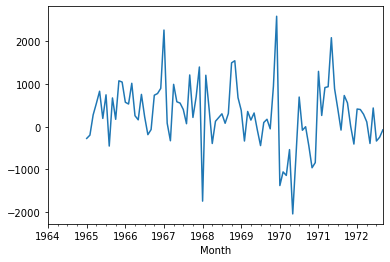

In [140]:
sales_df['First Seasonal Difference'].plot()

# Making Forecast

* Identification of an AR model is done by Partical Autocorrelation Function
* Identification of an MA model is done by Autocorrelation Function

In [142]:
#importing Partical Autocorrelation for AR and Autocorrelation for MA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

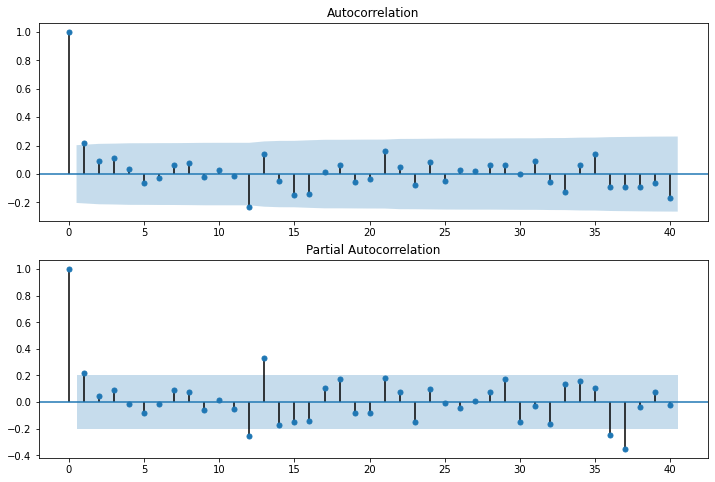

In [146]:
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(sales_df['First Seasonal Difference'].dropna(), lags = 40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(sales_df['First Seasonal Difference'].dropna(), lags = 40, ax=ax2)

* from the ACF plot it is clear that it starts to taper to 0 at x = 1
* from the PACF plot it it clear that it shuts off at x =1 
p = AR model lags
d = Differencing
q = MA model lags

In [147]:
#p = 1 from PACF plot
#d = 1 No. of seasonal differneces
#q = 1 from acf plot
from statsmodels.tsa.arima_model import ARIMA

In [148]:
# ARIMA should be selected only when our data is not seasonal. Hence, we use seasonal ARIMA
import statsmodels.api as sm

In [149]:
model = sm.tsa.statespace.SARIMAX(sales_df['Sales'], order = (1,1,1), seasonal_order = (1,1,1,12))
results = model.fit()

C:\Users\manch\New folder\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\manch\New folder\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


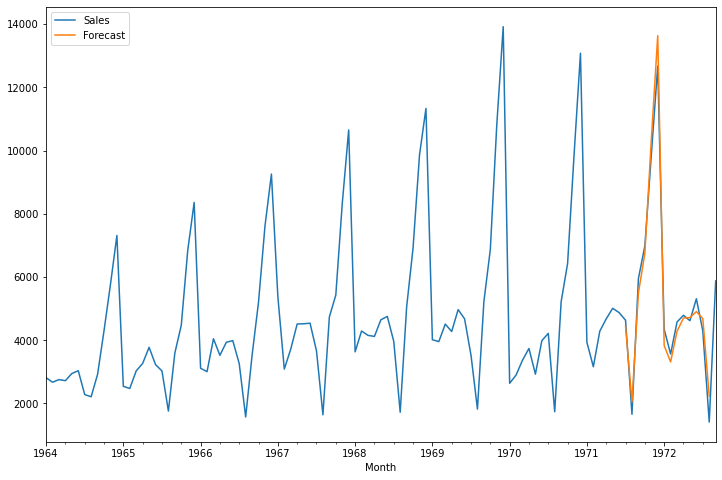

In [151]:
sales_df['Forecast'] = results.predict(start = 90, end = 103, dynamic = True)
sales_df[['Sales','Forecast']].plot(figsize=(12,8))

In [154]:
from pandas.tseries.offsets import DateOffset
future_dates = [sales_df.index[-1] + DateOffset(months=x) for x in range(0,24)]
future_dates_df = pd.DataFrame(index = future_dates[1:], columns = sales_df.columns)

In [155]:
future_dates_df.head()

,Sales,First Seasonal Difference,Forecast
1972-10-01,NaN,NaN,NaN
1972-11-01,NaN,NaN,NaN
1972-12-01,NaN,NaN,NaN
1973-01-01,NaN,NaN,NaN
1973-02-01,NaN,NaN,NaN


In [156]:
future_dates_df.tail()

,Sales,First Seasonal Difference,Forecast
1974-04-01,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN
1974-08-01,NaN,NaN,NaN


In [157]:
future_df = pd.concat([sales_df,future_dates_df])

In [158]:
future_df.head()

,Sales,First Seasonal Difference,Forecast
1964-01-01,2815,NaN,NaN
1964-02-01,2672,NaN,NaN
1964-03-01,2755,NaN,NaN
1964-04-01,2721,NaN,NaN
1964-05-01,2946,NaN,NaN


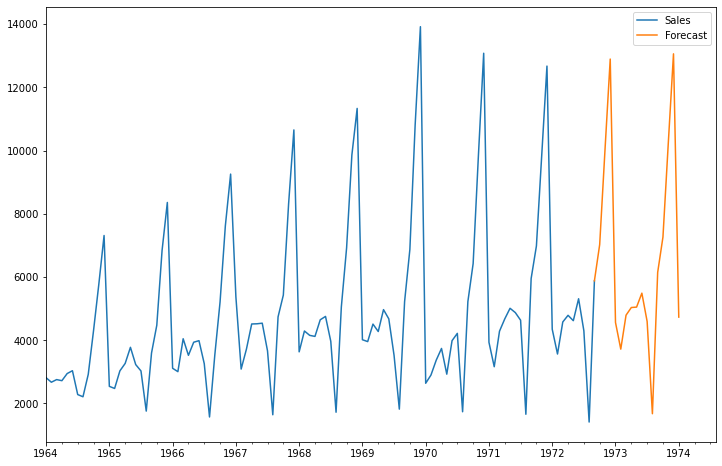

In [159]:
future_df['Forecast'] = results.predict( start = 104, end = 120, dynamic = True)
future_df[['Sales','Forecast']].plot(figsize = (12,8))

In [164]:
future_df['Forecast'].describe()

count       17.000000
mean      6593.956453
std       3168.919601
min       1676.137932
25%       4731.202727
50%       5488.574386
75%       7262.516932
max      13057.414581
Name: Forecast, dtype: float64

In [166]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                  105
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -738.402
Date:                            Sat, 10 Oct 2020   AIC                           1486.804
Time:                                    03:40:32   BIC                           1499.413
Sample:                                01-01-1964   HQIC                          1491.893
                                     - 09-01-1972                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2790      0.081      3.433      0.001       0.120       0.438
ma.L1         -0.9494      0.043    -22.335      0.000      -1.033      -0.866
ar.S.L12      -0.4544      0.303     -1.499      0.134      -1.049       0.140
ma.S.L12       0.2450      0.311      0.788      0.431      -0.365       0.855
sigma2      5.055e+05   6.12e+04      8.265      0.000    3.86e+05    6.25e+05
===================================================================================
Ljung-Box (Q):                       40.24   Jarque-Bera (JB):                 8.70
Prob(Q):                              0.46   Prob(JB):                         0.01
Heteroskedasticity (H):               1.18   Skew:                            -0.21
Prob(H) (two-sided):                  0.64   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""